# Figure 1

_Plot of the change in predicted class probability when a randomly picked basis direction q is added or subtracted (whichever decreases the loss more) with step size &epsilon;._

## Imports

In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torchvision import transforms

from imagenet.imagenet import ImageNetDataSet
from simple_blackbox_attack.cartesian_set import CartesianSearchVectors
from simple_blackbox_attack.dct_set import DCTSearchVectors
from simple_blackbox_attack.simba.simba import simba
from simple_blackbox_attack.simba.figure1 import simba_best_epsilon

## DataSet

In [7]:
IMAGE_FOLDER = "../../../../shared/data/imagenet/val"
LABEL_FILE = "../../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
META_FILE = "../../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/meta.mat"

In [8]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageNetDataSet(image_root=IMAGE_FOLDER, label_file=LABEL_FILE, meta_file=META_FILE, transform=preprocess)

## Model (ResNet50)

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True).to(DEVICE)
model.eval()

Using cache found in /home/dai/eko/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dai/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-BJnlChmF-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dai/eko/.cache/pypoetry/virtualenvs/replicating-simple-blackbox-attack-BJnlChmF-py3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Correctly classified images

In [10]:
indices = []
while len(indices) < 1000:
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = img.to(DEVICE)
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 1)
    if int(label) == predictions[0]:
        indices.append(sample_idx)

## Figure 1

In [11]:
runs_per_epsilon = 32

epsilons = np.linspace(0, 1, 32)

results_cartesian = np.zeros((runs_per_epsilon, len(epsilons)))
results_dct = np.zeros((runs_per_epsilon, len(epsilons)))

for i in range(runs_per_epsilon):
    sample_idx = random.choice(indices)
    img, label = dataset[sample_idx]
    img = img.to(DEVICE)
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probability, prediction = torch.topk(probabilities, 1)
    probability, prediction = probability[0], prediction[0]


    basis_cartesian = CartesianSearchVectors(img.size())
    basis_dct = DCTSearchVectors(img.size(), 1 / 8)

    cartesian_search_vector = basis_cartesian.get_random_vector().to(DEVICE)
    dct_search_vector = basis_dct.get_random_vector().to(DEVICE)

    for j, epsilon in enumerate(epsilons):
        prob_cart = simba_best_epsilon(model, img, cartesian_search_vector, epsilon)
        prob_dct = simba_best_epsilon(model, img, dct_search_vector, epsilon)
        results_cartesian[i, j] = prob_cart - probability
        results_dct[i, j] = prob_dct - probability

And plotting the results.

(-0.04, 0.03)

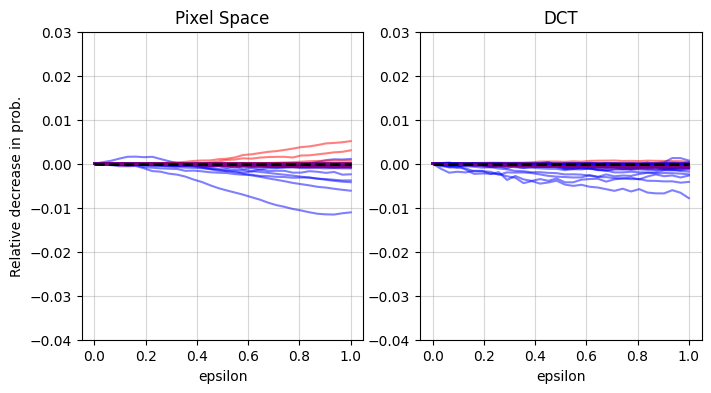

In [12]:
figure = plt.figure(figsize=(8, 4))
ax = figure.add_subplot(1, 2, 1)
mean_result = np.mean(results_cartesian, axis=0)
for i, result in enumerate(results_cartesian):
    color = "r" if np.mean(result) > 0 else "b"
    ax.plot(epsilons, result, color=color, alpha=0.5)
ax.plot(epsilons, np.mean(results_cartesian, axis=0), color="purple", linewidth=2)
ax.plot(epsilons, np.zeros(len(epsilons)), color="black", linewidth=2, linestyle="--")
ax.grid("on", alpha=0.5)
plt.title("Pixel Space")
plt.xlabel("epsilon")
plt.ylabel("Relative decrease in prob.")
plt.ylim([-0.04, 0.03])
ax = figure.add_subplot(1, 2, 2)
mean_result = np.mean(results_dct, axis=0)
for i, result in enumerate(results_dct):
    color = "r" if np.mean(result) > 0 else "b"
    ax.plot(epsilons, result, color=color, alpha=0.5)
ax.plot(epsilons, np.mean(results_dct, axis=0), color="purple", linewidth=2)
ax.plot(epsilons, np.zeros(len(epsilons)), color="black", linewidth=2, linestyle="--")
ax.grid("on", alpha=0.5)
plt.title("DCT")
plt.xlabel("epsilon")
plt.ylim([-0.04, 0.03])